<a href="https://colab.research.google.com/github/mirpouya/Western-University/blob/main/Advance_Image_Processing_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch has CIFAR-10 dataset in its library, I'm going to use the embedded CIFAR-10 for this assignment.

In [1]:
# importing required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

"torchvision.transform" is used for common image transformation on applied to PIL images, tensors representing images, or batches of images. Some of these transformations include:
* Resizing
* Cropping
* Rotation
* Flipping
* Converting to tensor
* Normalizing pixel values

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform= transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform= transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 13110417.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [5]:
# making dataloaders to iterate through batches of dataset
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True, num_workers=2)

In [6]:
# get the classes in the dataset
classes = trainloader.dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# function to visualize images in dataloaders

def data_loader_imshow(img):
    np_img = img.numpy()   # from tensor to numpy since matplotlib accepts only numpy arrays
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In image processing it is a tradition to represent an RGB image with (channels, height, width), however, matplotlib expect an image in the format of (height, width, channels). This is why I did
 `np.transpose(npimg, (1, 2, 0))`.


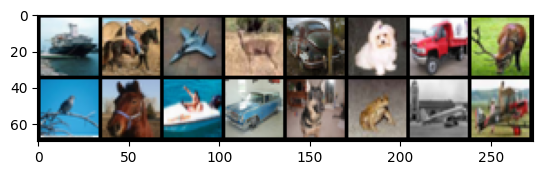

In [8]:
# visualize training data

# iterating through trainloader
for images, labels in trainloader:
    # Visualize images
    data_loader_imshow(torchvision.utils.make_grid(images))
    break

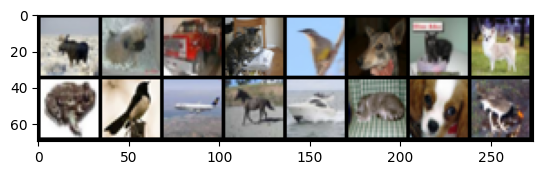

In [9]:
# visualize test data

for images, label in testloader:
  data_loader_imshow(torchvision.utils.make_grid(images))
  break

In [10]:
for images, labels in trainloader:
    # Print the shape of one of the images
    print(images.shape)
    break

torch.Size([16, 3, 32, 32])


<h1> <b> Convolutional Neural Network Model 1 </b> </h1>

In [11]:
class ConvNet_M1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [12]:
# Define your model
model_1 = ConvNet_M1().cuda()  # Move model to GPU

# Call the summary function directly on the GPU
summary(model_1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


<h1> <b> Convolutional Neural Network Model 2 </b> </h1>

<b> ConvNets output shape: </b> <br>
The output shape of a convolutional layer is calculated as follow: <br>

\begin{align}
\text{output_size} & = \left\lfloor \frac{{\text{input_size} + 2 \times \text{padding} - \text{kernel_size}}}{{\text{stride}}} \right\rfloor + 1 \\
\end{align}

output shape of <b> Maxpool layer </b>:

considering my maxpool is `self.pool = nn.MaxPool2d(2, 2)`: <br>
it indicates I am using a maxpool of kernel_size 2 and the stride of 2 as well

\begin{align}
\text{output_size} & = \left\lfloor \frac{{\text{input_size} + 2 \times \text{padding} - \text{kernel_size}}}{{\text{stride}}} \right\rfloor + 1
\end{align}

And for the max pooling layer:
\begin{align}
\text{output_size} & = \left\lfloor \frac{{\text{input_size} - \text{kernel_size}}}{{\text{stride}}} \right\rfloor + 1
\end{align}

so if the input shape is 32 by 32, the output will be:
\begin{align}
\text{output_size} & = \left\lfloor \frac{{\text{32} - \text{2}}}{{\text{2}}} \right\rfloor + 1 & = 16
\end{align}

In [13]:
class ConvNet_M2(nn.Module):
    def __init__(self):
        super(ConvNet_M2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #32*32*48
        x = F.relu(self.conv2(x)) #32*32*96
        x = self.pool(x) #16*16*96
        x = self.Dropout(x)
        x = F.relu(self.conv3(x)) #16*16*192
        x = F.relu(self.conv4(x)) #16*16*256
        x = self.pool(x) # 8*8*256
        x = self.Dropout(x)
        x = x.view(-1, 8*8*256) # reshape x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x

In [14]:
model_2 = ConvNet_M2().cuda()
summary(model_2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
            Conv2d-2           [-1, 96, 32, 32]          41,568
         MaxPool2d-3           [-1, 96, 16, 16]               0
           Dropout-4           [-1, 96, 16, 16]               0
            Conv2d-5          [-1, 192, 16, 16]         166,080
            Conv2d-6          [-1, 256, 16, 16]         442,624
         MaxPool2d-7            [-1, 256, 8, 8]               0
           Dropout-8            [-1, 256, 8, 8]               0
            Linear-9                  [-1, 512]       8,389,120
           Linear-10                   [-1, 64]          32,832
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 9,074,218
Trainable params: 9,074,218
Non-trainable params: 0
---------------------------

<h1> <b> Convolutional Neural Network Model 3 </b> </h1>

In [15]:
class ConvNet_M3(nn.Module):
    def __init__(self):
        super(ConvNet_M3, self).__init__()  # Corrected the superclass call
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=(1,1))

        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=8*8*512, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #32*32*48
        x = F.relu(self.conv2(x)) #32*32*96

        x = self.pool(x) #16*16*96
        x = self.Dropout(x)

        x = F.relu(self.conv3(x)) #16*16*192
        x = F.relu(self.conv4(x)) #16*16*256
        x = F.relu(self.conv5(x)) #16*16*512

        x = self.pool(x) # 8*8*512
        x = self.Dropout(x)
        x = x.view(-1, 8*8*512) # reshape x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x


In [16]:
model_3 = ConvNet_M3().cuda()
summary(model_3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
            Conv2d-2           [-1, 96, 32, 32]          41,568
         MaxPool2d-3           [-1, 96, 16, 16]               0
           Dropout-4           [-1, 96, 16, 16]               0
            Conv2d-5          [-1, 192, 16, 16]         166,080
            Conv2d-6          [-1, 256, 16, 16]         442,624
            Conv2d-7          [-1, 512, 16, 16]       1,180,160
         MaxPool2d-8            [-1, 512, 8, 8]               0
           Dropout-9            [-1, 512, 8, 8]               0
           Linear-10                  [-1, 512]      16,777,728
           Linear-11                   [-1, 64]          32,832
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 18,642,986
Trainable para

<h1> <b> Train model 1 </b> </h1>

In [17]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [18]:
# Define your model
model_1s = ConvNet_M1().to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1s.parameters(), lr=0.001)  # Example optimizer, you can change this

# Training loop
def train(model, trainloader, testloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Calculate test accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {running_loss / len(trainloader):.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%, '
              f'Test Accuracy: {test_accuracy:.2f}%')

# Train the model
train(model_1s, trainloader, testloader, criterion, optimizer, epochs=20)


Epoch [1/20], Training Loss: 1.7251, Training Accuracy: 36.38%, Test Accuracy: 43.59%
Epoch [2/20], Training Loss: 1.4484, Training Accuracy: 47.28%, Test Accuracy: 46.85%
Epoch [3/20], Training Loss: 1.3338, Training Accuracy: 52.04%, Test Accuracy: 51.78%
Epoch [4/20], Training Loss: 1.2575, Training Accuracy: 55.11%, Test Accuracy: 55.04%
Epoch [5/20], Training Loss: 1.2023, Training Accuracy: 56.99%, Test Accuracy: 53.42%
Epoch [6/20], Training Loss: 1.1617, Training Accuracy: 58.51%, Test Accuracy: 56.11%
Epoch [7/20], Training Loss: 1.1212, Training Accuracy: 59.98%, Test Accuracy: 58.07%
Epoch [8/20], Training Loss: 1.0935, Training Accuracy: 61.18%, Test Accuracy: 57.83%
Epoch [9/20], Training Loss: 1.0608, Training Accuracy: 61.98%, Test Accuracy: 57.86%
Epoch [10/20], Training Loss: 1.0360, Training Accuracy: 62.70%, Test Accuracy: 58.41%
Epoch [11/20], Training Loss: 1.0142, Training Accuracy: 63.90%, Test Accuracy: 58.86%
Epoch [12/20], Training Loss: 0.9915, Training Accur

<h1> <b> Train model 2 </b> <h1>

In [19]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [20]:
# Define your model
model_21m = ConvNet_M2().to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_21m.parameters(), lr=0.0001)  # Decrease learning rate

# Training loop
def train(model, trainloader, testloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Calculate test accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {running_loss / len(trainloader):.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%, '
              f'Test Accuracy: {test_accuracy:.2f}%')

# Train the model for 20 epochs
train(model_21m, trainloader, testloader, criterion, optimizer, epochs=20)

Epoch [1/20], Training Loss: 1.6925, Training Accuracy: 38.26%, Test Accuracy: 51.14%
Epoch [2/20], Training Loss: 1.3061, Training Accuracy: 53.31%, Test Accuracy: 59.42%
Epoch [3/20], Training Loss: 1.1253, Training Accuracy: 60.31%, Test Accuracy: 65.07%
Epoch [4/20], Training Loss: 0.9774, Training Accuracy: 65.88%, Test Accuracy: 67.63%
Epoch [5/20], Training Loss: 0.8631, Training Accuracy: 70.06%, Test Accuracy: 69.70%
Epoch [6/20], Training Loss: 0.7622, Training Accuracy: 73.52%, Test Accuracy: 72.55%
Epoch [7/20], Training Loss: 0.6748, Training Accuracy: 76.82%, Test Accuracy: 73.57%
Epoch [8/20], Training Loss: 0.5897, Training Accuracy: 79.59%, Test Accuracy: 74.76%
Epoch [9/20], Training Loss: 0.5090, Training Accuracy: 82.56%, Test Accuracy: 75.56%
Epoch [10/20], Training Loss: 0.4352, Training Accuracy: 84.88%, Test Accuracy: 76.56%
Epoch [11/20], Training Loss: 0.3620, Training Accuracy: 87.53%, Test Accuracy: 75.26%
Epoch [12/20], Training Loss: 0.3013, Training Accur

<h1> <b> Train model 3 </b> <h1>

In [21]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [22]:
# Define your model
model_3l = ConvNet_M3().to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3l.parameters(), lr=0.0001)  # Decrease learning rate

# Training loop
def train(model, trainloader, testloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Calculate test accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {running_loss / len(trainloader):.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%, '
              f'Test Accuracy: {test_accuracy:.2f}%')

# Train the model for 30 epochs
train(model_3l, trainloader, testloader, criterion, optimizer, epochs=30)

Epoch [1/30], Training Loss: 1.6697, Training Accuracy: 38.76%, Test Accuracy: 54.00%
Epoch [2/30], Training Loss: 1.2194, Training Accuracy: 56.74%, Test Accuracy: 62.16%
Epoch [3/30], Training Loss: 1.0149, Training Accuracy: 64.62%, Test Accuracy: 64.71%
Epoch [4/30], Training Loss: 0.8619, Training Accuracy: 69.86%, Test Accuracy: 70.82%
Epoch [5/30], Training Loss: 0.7404, Training Accuracy: 74.13%, Test Accuracy: 71.45%
Epoch [6/30], Training Loss: 0.6271, Training Accuracy: 78.30%, Test Accuracy: 74.60%
Epoch [7/30], Training Loss: 0.5226, Training Accuracy: 81.83%, Test Accuracy: 75.38%
Epoch [8/30], Training Loss: 0.4276, Training Accuracy: 85.06%, Test Accuracy: 76.04%
Epoch [9/30], Training Loss: 0.3371, Training Accuracy: 88.31%, Test Accuracy: 76.46%
Epoch [10/30], Training Loss: 0.2641, Training Accuracy: 90.73%, Test Accuracy: 76.38%
Epoch [11/30], Training Loss: 0.2074, Training Accuracy: 92.76%, Test Accuracy: 75.84%
Epoch [12/30], Training Loss: 0.1591, Training Accur

<h1> <b> Training model 2 with normalization of data, and different learning rate and regularization </b> </h1>

As I researched, most of the people set the mean and standard deviation to 0.5 when it comes to normalize CIFAR-10. <br>
The pixel values ranges from 0 to 255, 0 denotes pure black, and 255 total whitness. First the pixel values get devided by 255, so they scale in the range of [0 - 1] then by setting the mean to 0.5 it shifts them from -0.5 to 0.5 (centering them around 0), and by setting std=0.5, the standard deviation of sample dataset, gets to be 0.5 around the center.

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset_normalized = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform= transform)
testset_normalized = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# data loaders
# making dataloaders to iterate through batches of dataset
batch_size = 8

trainloader_normalized = torch.utils.data.DataLoader(trainset_normalized, batch_size = batch_size, shuffle=True, num_workers=2)
testloader_normalized = torch.utils.data.DataLoader(testset_normalized, batch_size = batch_size, shuffle=True, num_workers=2)

In [25]:
# Define your model
model_2_2m = ConvNet_M2().to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_2m.parameters(), lr=0.0002)  # Decrease learning rate

train_accuracy_list = []
test_accuracy_list = []

train_loss_list = []
test_loss_list = []

# Training loop
def train(model, trainloader, testloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs_train = model(inputs)

            loss = criterion(outputs_train, labels)
            train_loss_list.append(loss)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs_train.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)

        # Calculate test accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
                outputs_test = model(images)

                loss_test = criterion(outputs_test, labels)
                test_loss_list.append(loss_test)

                _, predicted = torch.max(outputs_test.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracy_list.append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {running_loss / len(trainloader):.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%, '
              f'Test Accuracy: {test_accuracy:.2f}%')

# Train the model for 20 epochs
train(model_2_2m, trainloader_normalized, testloader_normalized, criterion, optimizer, epochs=20)

Epoch [1/20], Training Loss: 1.4323, Training Accuracy: 48.19%, Test Accuracy: 63.39%
Epoch [2/20], Training Loss: 0.9400, Training Accuracy: 67.41%, Test Accuracy: 72.96%
Epoch [3/20], Training Loss: 0.7204, Training Accuracy: 75.23%, Test Accuracy: 76.17%
Epoch [4/20], Training Loss: 0.5744, Training Accuracy: 80.21%, Test Accuracy: 78.17%
Epoch [5/20], Training Loss: 0.4507, Training Accuracy: 84.60%, Test Accuracy: 79.26%
Epoch [6/20], Training Loss: 0.3526, Training Accuracy: 87.94%, Test Accuracy: 79.88%
Epoch [7/20], Training Loss: 0.2713, Training Accuracy: 90.71%, Test Accuracy: 80.38%
Epoch [8/20], Training Loss: 0.2140, Training Accuracy: 92.73%, Test Accuracy: 80.11%
Epoch [9/20], Training Loss: 0.1694, Training Accuracy: 94.24%, Test Accuracy: 80.24%
Epoch [10/20], Training Loss: 0.1416, Training Accuracy: 95.28%, Test Accuracy: 80.15%
Epoch [11/20], Training Loss: 0.1190, Training Accuracy: 96.05%, Test Accuracy: 79.76%
Epoch [12/20], Training Loss: 0.1048, Training Accur

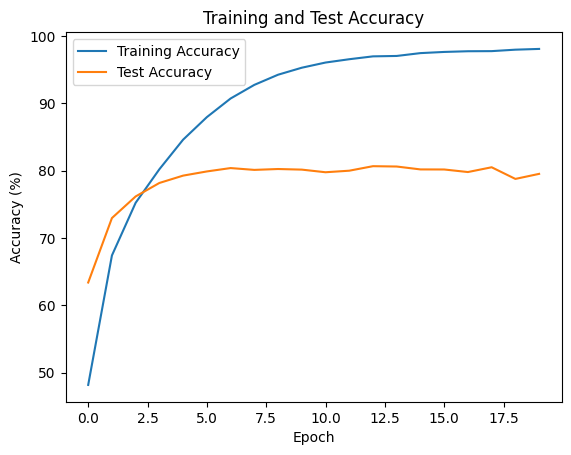

In [26]:
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

<h2> <b> Discussion: </b> </h2> <br>

Model 1 is too small with an insufficient number of parameters to fully capture the complexity of the dataset. So after a few epochs of training the accuracy neither in training nor in testing increases. Model two is much larger, with roughly 9M parameters. Therefore, it is complex enough to recognize the patterns of each class in the dataset. However, after 10 epochs of training the test accuracy gets to a plateau of approximately 75%, and even though training accuracy increases, the test accuracy does not. The dropout layers in model 2, make the model more robust, and less prone to overfitting, but with the inclusion of regularization in the loss and training process, the model will be more robust and less likely to overfit to the training set. Model 3 is very big and has twice the number of parameters which Model 2 has. From the training and test accuracy in the 30 epochs, it is concluded that this level of complexity is redundant and the model cannot perform better than model 2 even with 9M more parameters. To tackle this issue, more data is needed for this model so data augmentation might be a good solution if we want to stick with model 3. But with this amount of data, model 3 only is a computational burden. Model 3 train accuracy is near 100%, so it is safe to say that it overfits the data.
I trained model 2, with a bigger learning rate and the normalization of input data, but the same number of epochs for training, the result demonstrates the enhancement in the model performance after the fifth training epoch. The accuracy of the model on the test set with a bigger learning rate and normalization of data is considerably better. Regularization and data augmentation make it dominate the result, since after the 10th epoch, the test result does not change that much as well.
